In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pillow
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt
import time
import os
import copy
import requests
from PIL import Image
from io import BytesIO
plt.ion() # インタラクティブ・モード

In [ ]:
# 訓練データ用のデータ拡張と正規化
# 検証データ用には正規化のみ実施
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'im_insert': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/drive/MyDrive/hackthon/"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val','im_insert']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','im_insert']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','im_insert']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


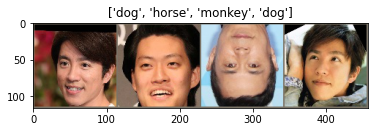

In [ ]:
# 画像の可視化
def imshow(inp, title=None):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# モデル予測値の可視化
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# ConvNetをファインチューニングする方法
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# ここでは，各出力サンプルのサイズは2に設定されています
# なお、NN.Linear(num_ftrs, len(class_names))という書き方で一般化することもできます。
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# ネットワークのすべてのパラメータが最適化対象です
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7エポックごとに学習率を1/10ずつ減衰させます
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft2 = models.resnet18(pretrained=True)
model_ft2.fc = nn.Linear(num_ftrs,8)
model_ft2 = model_ft2.to(device)
omomi = torch.load("/content/drive/MyDrive/hackthon/result/model_ft.pth")
model_ft2.load_state_dict(omomi)
# model = nn.Module().to(device)
# load_state_dict(torch.load(path_to_data, map_location=device_name), strict=False)

print(type(model_ft2))
print(type(model_ft))

<class 'torchvision.models.resnet.ResNet'>
<class 'torchvision.models.resnet.ResNet'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


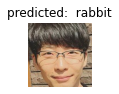

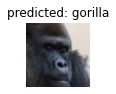

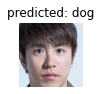

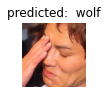

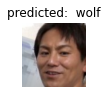

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
   

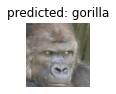

In [ ]:
visualize_model(model_ft2) 

In [ ]:
img_org = Image.open('/content/drive/MyDrive/hackthon/im_insert/gorilla/face02.jpg')
print(img_org.size)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
new_img = preprocess(img_org)
new_img_batch = new_img[None]
print(new_img_batch.shape)
model_ft2.eval()
result = model_ft2(new_img_batch)


(112, 112)
torch.Size([1, 3, 112, 112])


In [ ]:
# idx = torch.argmax(result[0])
# idx.ndim
_, preds = torch.max(result, 1)

print('predicted: {}'.format(class_names[preds[0]]))

predicted:  rabbit


In [ ]:
result

tensor([[ 0.4162,  4.4405,  1.0791,  3.3403,  1.6157, -7.3897,  1.2880, -3.9546]],
       grad_fn=<AddmmBackward0>)

In [ ]:
inputs.shape

torch.Size([4, 3, 112, 112])

In [ ]:
# モデル予測値の可視化
def visualize_model_you(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['im_insert']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


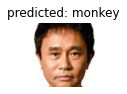

In [ ]:
visualize_model_you(model_ft2) 